# Lab 2 - RandomForest and KNN (Classification Modeling)

__Team Members__
- Name 1: Jorge Olmos
- Name 2: Bosang Yun
- Name 3: Yucheol Shin
- Name 4: Siu Wai Yeung

# Content
* [Data Importing and Cleaning](#Data-Importing-and-Cleaning)
* [Select modeling technique](#Select-modeling-technique)
* [Generate Test Design](#Generate-Test-Design)
    - [Given the coefficients of each feature, why do you think some features are more important?](#question1)
    - [Do the chosen support vectors provide any insight into the data?](#question2)
    - [So how can we fix this problem?](#question3)
* [Build Model](#Build-Model)
* [Assess Model](#Assess-Model)
    - [Does one type of model offer superior performance over another in terms of prediction accuracy?](#question4)
    - [In terms of training time or efficiency?](#question5)


# Data Importing and Cleaning<a id='Data-Importing-and-Cleaning'/>

In [3]:
import pandas as pd
import numpy as np

hotel_bookings = pd.read_csv('https://raw.githubusercontent.com/olmosjorge28/DS7331_ML1_ASSINGMENTS/main/hotel_bookings.csv') # read in the csv file
hotel_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/15
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/15
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/15
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/15
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/15


In [4]:
import math
from datetime import date


hotel_bookings_transform = hotel_bookings
hotel_bookings_transform= hotel_bookings_transform.drop(columns=['agent','company', 'country'])

hotel_bookings_transform['meal']= hotel_bookings_transform['meal'].apply(lambda x: 'SC' if  x == 'Undefined'  else x)
hotel_bookings_transform['children']= hotel_bookings_transform['children'].apply(lambda x: 0 if  math.isnan(x)  else x)
hotel_bookings_transform['market_segment']= hotel_bookings_transform['market_segment'].apply(lambda x: 'Online TA' if  x == 'Undefined'  else x)
hotel_bookings_transform['distribution_channel']= hotel_bookings_transform['distribution_channel'].apply(lambda x: 'TA/TO' if  x == 'Undefined'  else x)


hotel_bookings_transform['hotel']=hotel_bookings_transform['hotel'].astype('category').cat.codes
hotel_bookings_transform['market_segment']=hotel_bookings_transform['market_segment'].astype('category').cat.codes
hotel_bookings_transform['meal']=hotel_bookings_transform['meal'].astype('category').cat.codes
hotel_bookings_transform['reservation_status']=hotel_bookings_transform['reservation_status'].astype('category').cat.codes
hotel_bookings_transform['distribution_channel']=hotel_bookings_transform['distribution_channel'].astype('category').cat.codes
hotel_bookings_transform['reserved_room_type']=hotel_bookings_transform['reserved_room_type'].astype('category').cat.codes
hotel_bookings_transform['assigned_room_type']=hotel_bookings_transform['assigned_room_type'].astype('category').cat.codes
hotel_bookings_transform['deposit_type']=hotel_bookings_transform['deposit_type'].astype('category').cat.codes
hotel_bookings_transform['customer_type']=hotel_bookings_transform['customer_type'].astype('category').cat.codes

assign_month = {"arrival_date_month": {"January": 1, "February": 2, "March": 3, "April": 4,"May": 5,"June": 6,"July": 7,"August": 8,"September": 9,"October": 10,"November": 11,"December": 12}}
hotel_bookings_transform = hotel_bookings_transform.replace(assign_month)

# Convert Date to Ordinal
import datetime as dt
hotel_bookings_transform['reservation_status_date'] = pd.to_datetime(hotel_bookings_transform['reservation_status_date'])
hotel_bookings_transform['reservation_status_date'] = hotel_bookings_transform['reservation_status_date'].map(dt.datetime.toordinal)

hotel_bookings_transform=hotel_bookings_transform.assign(booking_day_of_year = hotel_bookings_transform["arrival_date_year"].astype(str) + '-' + 
hotel_bookings_transform["arrival_date_month"].astype(str) + '-' +hotel_bookings_transform["arrival_date_day_of_month"].astype(str))
hotel_bookings_transform['booking_day_of_year']=pd.to_datetime(hotel_bookings_transform.booking_day_of_year)
hotel_bookings_transform['booking_day_of_year']=hotel_bookings_transform['booking_day_of_year'].map(lambda x: x.toordinal() - date(x.year, 1, 1).toordinal() + 1)


hotel_bookings_transform=hotel_bookings_transform.drop(columns=['arrival_date_year','reservation_status_date'])
#hotel_bookings_transform['booking_date']=hotel_bookings_transform['booking_date'].map(dt.datetime.toordinal)

# Select modeling technique<a id='Select-modeling-technique'/>

### Model Comparision
For this lab we selected Logistic Regression and SVM as we are trying to predict classification data. The following lays out the pros and cons of each modeling used for this lab. The detailed explanation on how the models performed will be discussed later in this lab. 

 - Logistic regression 
	- Advantage
		- Performs well when data is linearly separable. 
		- Provides model coefficients as indicators of feature importance. 
		
	- Disadvantages
		- Limited only to linear boundary
		- Bounded by the assumption of linearity between dependent features and independent features. 

 - SVM
	- Advantages
		- Provides good accuracy
		- Uses less memory. 
		- Offers clear margin of separation. 
	- Disadvantages 
		- Not ideal for large dataset due to high training time. 
        - Works poorly with highly correlated features and is very sensitive to the type of kernel used

# Generate Test Design: <a id='Generate-Test-Design'/>

## Normalization

- SVM tries to maximize the distance between the support vectors and the separating plane. 
- Prior to conducting SVM, we need to normalize the dataset so we can get rid of bias and dominance of certain features over others. 
- The result of applying normalized dataset will be having the same influence on the distance metric, thus boosting the accuracy of the model. 

In [5]:
X=hotel_bookings_transform.drop(columns=['is_canceled','reservation_status','meal'])
y=hotel_bookings_transform.is_canceled
columns = X.columns

In [6]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
scaler

scaler.mean_
scaler.scale_

X_scaled = pd.DataFrame(scaler.transform(X),columns=columns)

Verifying each feature has a mean of zero:

In [7]:
X_scaled.mean(axis=0)

hotel                            -2.148285e-13
lead_time                         3.358325e-16
arrival_date_month               -1.221612e-14
arrival_date_week_number          4.093983e-15
arrival_date_day_of_month        -9.159196e-16
stays_in_weekend_nights           3.928971e-14
stays_in_week_nights             -2.182022e-14
adults                            5.708995e-15
children                         -6.989886e-16
babies                            5.955017e-15
market_segment                    4.484909e-15
distribution_channel              2.185129e-14
is_repeated_guest                -3.493540e-14
previous_cancellations            1.741766e-14
previous_bookings_not_canceled   -1.286381e-15
reserved_room_type                1.246924e-13
assigned_room_type                9.462049e-14
booking_changes                  -7.015186e-14
deposit_type                      1.754553e-13
days_in_waiting_list             -1.846956e-14
customer_type                    -2.170149e-14
adr          

Verifying that the standard deviation should be 1:

In [8]:
X_scaled.std(axis=0)

hotel                             1.000004
lead_time                         1.000004
arrival_date_month                1.000004
arrival_date_week_number          1.000004
arrival_date_day_of_month         1.000004
stays_in_weekend_nights           1.000004
stays_in_week_nights              1.000004
adults                            1.000004
children                          1.000004
babies                            1.000004
market_segment                    1.000004
distribution_channel              1.000004
is_repeated_guest                 1.000004
previous_cancellations            1.000004
previous_bookings_not_canceled    1.000004
reserved_room_type                1.000004
assigned_room_type                1.000004
booking_changes                   1.000004
deposit_type                      1.000004
days_in_waiting_list              1.000004
customer_type                     1.000004
adr                               1.000004
required_car_parking_spaces       1.000004
total_of_sp

## Feature Selection 

Running initial model to select best parameters to be used for RFE selection:

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit

#cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size=0.2,random_state=10)

regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [10]
              ,'solver': ['lbfgs']
              ,'max_iter':[500,1000]
             }


from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , scoring='accuracy')

regGridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:   57.8s finished


GridSearchCV(estimator=LogisticRegression(), n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', 'none'],
                         'max_iter': [500, 1000], 'penalty': ['l2'],
                         'random_state': [10], 'solver': ['lbfgs']},
             scoring='accuracy', verbose=1)

### RFE Selection

In [14]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#for loop
rfecv = RFECV(estimator=classifierEst, step=1, scoring='accuracy')
rfecv.fit(X_train, y_train)

RFECV(estimator=LogisticRegression(C=1, class_weight='none', max_iter=500,
                                   random_state=10),
      scoring='accuracy')

Here we're examining the plot of the categorical values of interest and looking at the optimal number of features:

Optimal number of features : 25


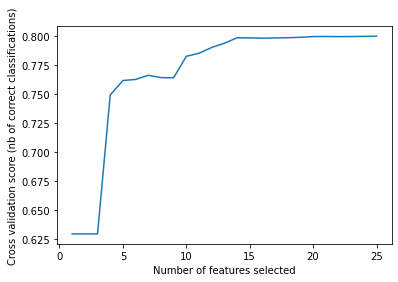

In [15]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [16]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_scaled.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top_features = rfe_ft_imp_df.head(50)

top_features

,feature_names,weights
24,booking_day_of_year,0.799847
23,total_of_special_requests,0.799722
20,customer_type,0.799638
22,required_car_parking_spaces,0.799564
19,days_in_waiting_list,0.799544
21,adr,0.799512
18,deposit_type,0.798926
17,booking_changes,0.798580
13,previous_cancellations,0.798497
14,previous_bookings_not_canceled,0.798455


### Embedded method for feature selection
- 26 features are selected based on the weight distribution from the Recurvesive features selection result. 
- Embedded method is utilized to reduce the number of features further down with Lasso regularization method.
- LASSO regularization method penalizes coefficients of features and remove those that are with coefficient=0.
- A total of 7 features are selected : 
    - deposit_type,
    - lead_time,
    - market_segment,
    - distribution_channel,
    - total_of_special_requests,
    - required_car_parking_spaces,
    - previous_bookings_not_canceled,
    - adr

In [17]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(X_sel, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_sel,y))
coef = pd.Series(reg.coef_, index = X_sel.columns)

NameError: name 'X_sel' is not defined

In [278]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 6 variables and eliminated the other 19 variables


In [18]:
# Visualizing the feature importance using LASSO 

import matplotlib.pyplot as plt
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

NameError: name 'coef' is not defined

Text(0.5, 1.0, 'Feature importance using Lasso Model')

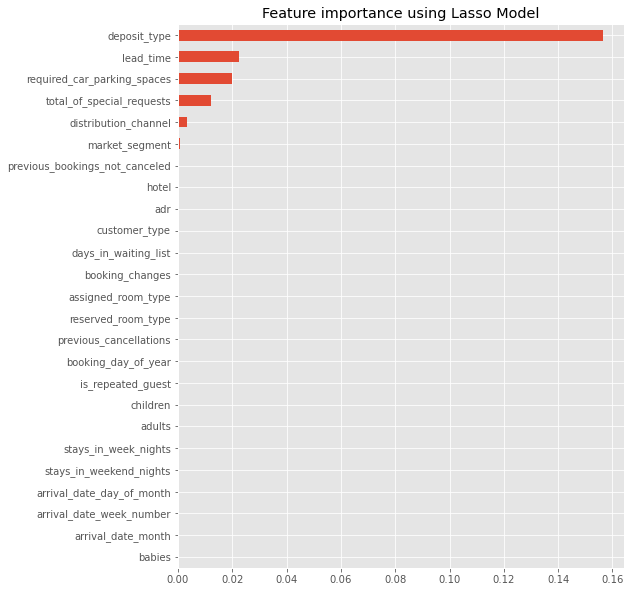

In [280]:
imp_coef = coef.sort_values()
abs_imp_coef = abs(imp_coef)
abs_imp_coef=abs_imp_coef.sort_values()

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
abs_imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")



## Cross Validation
- We applied the feature selection from above and decided to use 80:20 training/test split along with using gridSearch. 
- We will be using gridSearch function, which has 5 fold cross validation. 

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

X_sel = X_scaled[[
'deposit_type',
'lead_time',
'market_segment',
'distribution_channel',
'total_of_special_requests',
'required_car_parking_spaces',
'previous_bookings_not_canceled',
'adr'
]]

X_train, X_test, y_train, y_test = train_test_split(X_sel, y,test_size=0.2,random_state=10)

# Build Model<a id='Build-Model'/>

## KNN
- Checking to see if target variable("iscanceled") is balanced between 0 and 1.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Adapted from:
# https://www.featureranking.com/tutorials/machine-learning-tutorials/information-gain-computation/
def gini_index(y):
    probs = pd.value_counts(y,normalize=True)
    return 1 - np.sum(np.square(probs))

def plot_class_dist(y):
    fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
    class_ct = len(np.unique(y))
    vc = pd.value_counts(y)
    print('Total Records', len(y))
    print('Total Classes:', class_ct)
    print('Class Gini Index', gini_index(y))
    print('Smallest Class Id:',vc.idxmin(),'Records:',vc.min())
    print('Largest Class Id:',vc.idxmax(),'Records:',vc.max())
    print('Accuracy when Guessing:', np.round( (1 / len(np.unique(y))) * 100, 2), '%')

    sns.distplot(y, ax=axarr[0], bins=class_ct).set_title('LFW Class Distribution');
    sns.distplot(y, ax=axarr[1], kde=False, bins=class_ct).set_title('LFW Class Counts');


Total Records 95512
Total Classes: 2
Class Gini Index 0.4663281470064755
Smallest Class Id: 1 Records: 35363
Largest Class Id: 0 Records: 60149
Accuracy when Guessing: 50.0 %


/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


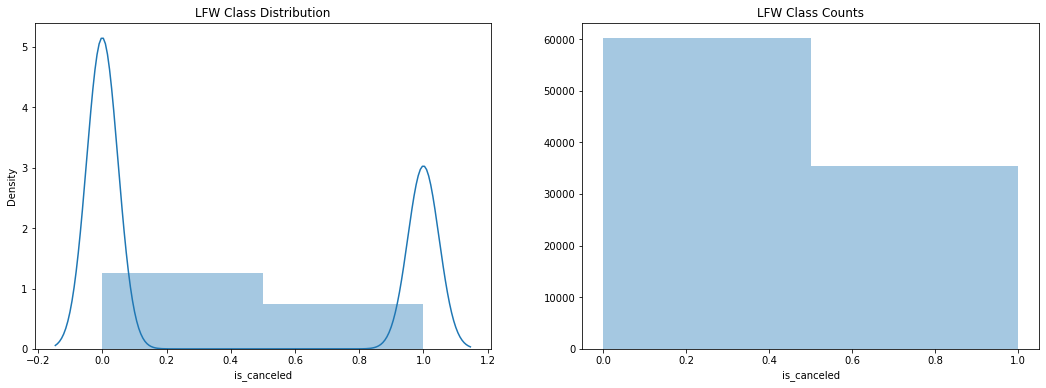

In [48]:
plot_class_dist(y_train)

### Using SMOTE technique to oversample y_train and balance 0 and 1. 

In [49]:
import imblearn
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

Total Records 120298
Total Classes: 2
Class Gini Index 0.5
Smallest Class Id: 1 Records: 60149
Largest Class Id: 1 Records: 60149
Accuracy when Guessing: 50.0 %


/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


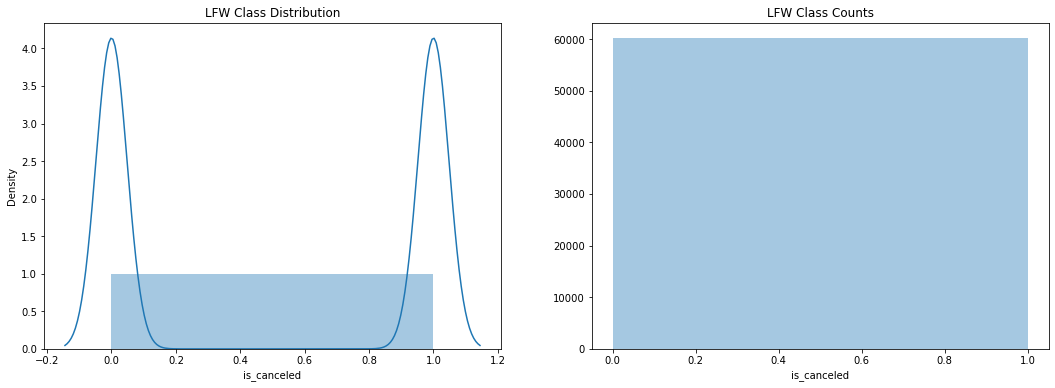

In [50]:
plot_class_dist(y_train)

Training set score: 0.84
Validation set score: 0.81


/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


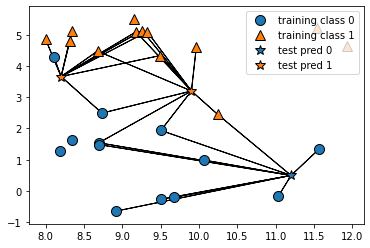

In [37]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import mglearn.plots

knn = KNeighborsClassifier(n_neighbors=10)
model=knn.fit(X_train, y_train)
pred = model.predict(X_test)
pred
print("Training set score: {:.2f}".format(knn.score(X_train, y_train)))
print("Validation set score: {:.2f}".format(knn.score(X_test, y_test)))

# KNN Plot
mglearn.plots.plot_knn_classification(n_neighbors=10)
plt.show()